### Scan for optimal npatch and n_bootstrap values

Number of galaxies after cuts: 21857
Number of random points: 2185700


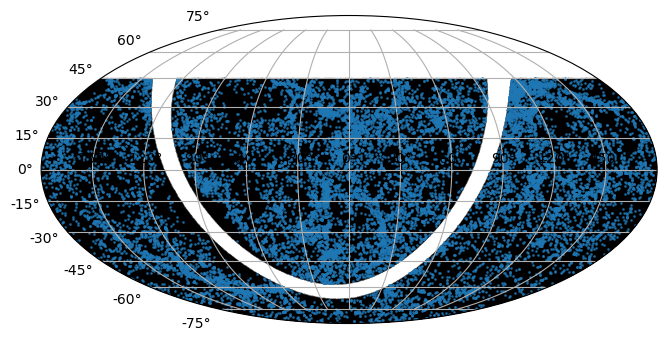


Computing for npatch = 100...
patch gal counts min/med/mean = 77/191.5/218.6

Computing for npatch = 200...
patch gal counts min/med/mean = 39/98.5/109.3

Computing for npatch = 300...
patch gal counts min/med/mean = 11/66.0/72.9

Computing for npatch = 400...
patch gal counts min/med/mean = 12/49.0/54.6

Computing for npatch = 500...
patch gal counts min/med/mean = 3/38.0/43.7

Computing for npatch = 600...
patch gal counts min/med/mean = 4/32.0/36.4
Using optimal_npatch = 100

Computing for n_bootstrap = 100...
gcat: npatch = 100  patch_centers.shape = (100, 3)
Number of patch centers: 100
[[ 1.00000000e+00  6.29724770e-12 -2.59503564e-11]
 [ 1.00000000e+00  1.10856231e-11 -3.85378131e-11]
 [ 1.00000000e+00  9.00993637e-12 -1.50775049e-11]
 [ 1.00000000e+00  2.99167164e-11 -3.02452940e-11]
 [ 1.00000000e+00  4.07334115e-11 -3.43201246e-11]
 [ 1.00000000e+00  2.68944891e-11 -1.37779418e-11]
 [ 1.00000000e+00  4.36646548e-12 -3.37334803e-12]
 [ 1.00000000e+00  1.14014036e-11 -6.388124

KeyboardInterrupt: 

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr

# --------------------------- User parameters ---------------------------
GLADE_FILE = "../../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
FLUX_FILE = "../../data/Auger/flux_a8_lb.dat"

npatch_list = [100, 200, 300, 400, 500, 600]
n_bootstrap_list = [100, 200, 500, 1000, 2000]

N_RAND_PER_GAL = 100
MIN_CZ = 1200
MAX_CZ = 6000
MK_CUT = -20.0
MAX_DEC = 45.0
THETA_CUTOFF = 20.0  # degrees for your metric

TC_CONFIG = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "cross_patch_weight": 'geom'
}

# --------------------------- Helper functions ---------------------------

def read_GLADE(cols_to_use, cz_min=MIN_CZ, dL_max=200, filename=GLADE_FILE):
    from get_masks import get_milkyway_mask

    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
            filename,
            sep=r'\s+',  # future-proof replacement for delim_whitespace
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        mask = (
            np.isfinite(chunk["M_K"]) &
            np.isfinite(chunk["d_L"]) &
            np.isfinite(chunk["RA"]) &
            np.isfinite(chunk["Dec"])
        )
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # apply Milky Way mask and dec cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec'] < MAX_DEC]

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=MAX_DEC, seed=None):
    from get_masks import get_milkyway_mask
    rng = np.random.default_rng(seed)
    factor = 4
    rand_ra = rng.uniform(0, 360, N_total * factor)
    rand_sindec = rng.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total * factor)
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError("Not enough random points generated after masking")
    return rand_ra, rand_dec


def compute_corr(gal_ra, gal_dec,
                 rand_ra_fixed, rand_dec_fixed,
                 flux_ra, flux_dec, flux_val, npatch):
    """
    Returns: meanr, xi, varxi
    Prints diagnostics about patch assignment.
    """
    # Build galaxy catalog with patches
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec,
                            ra_units='deg', dec_units='deg',
                            npatch=npatch)

    # Basic checks
    if not hasattr(gcat, 'patch_centers'):
        raise RuntimeError("gcat has no patch_centers attribute")
    pc = gcat.patch_centers
    # patch_centers should be (npatch,3) on sphere (x,y,z)
    print("gcat: npatch =", getattr(gcat, 'npatch', npatch), " patch_centers.shape =", getattr(pc, 'shape', None))

    random_ra, random_dec = generate_RanCat(len(gal_ra) * N_RAND_PER_GAL, seed=67890)

    # Build random catalog using same patch centers (recomputes membership)
    rand_cat = treecorr.Catalog(ra=random_ra, dec=random_dec,
                                ra_units='deg', dec_units='deg',
                                patch_centers=gcat.patch_centers)

    # Step 3 — now you can print patch centers
    print("Number of patch centers:", len(rand_cat.patch_centers))
    #print(rand_cat.patch_centers)

    # Diagnostics: check patch indices for randoms and galaxies
    # Use the local npatch for minlength
    rand_counts = np.bincount(rand_cat.patch, minlength=npatch)
    gal_counts = np.bincount(gcat.patch, minlength=npatch)

    print("gal patch counts min/med/mean =",
          gal_counts.min(), np.median(gal_counts), gal_counts.mean())
    print("rand patch counts min/med/mean =",
          rand_counts.min(), np.median(rand_counts), rand_counts.mean())

    # Warn about empty patches (randoms or galaxies)
    n_empty_rand = int((rand_counts == 0).sum())
    n_empty_gal = int((gal_counts == 0).sum())
    if n_empty_rand > 0:
        print(f"WARNING: {n_empty_rand}/{npatch} random patches are empty.")
    if n_empty_gal > 0:
        print(f"WARNING: {n_empty_gal}/{npatch} galaxy patches are empty.")

    # Flux catalog
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                            ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(TC_CONFIG)
    rk = treecorr.NKCorrelation(TC_CONFIG)

    print("Catalog patches =", gcat.npatch)
    print("NK var_method   =", nk.var_method)

    nk.process(gcat, fcat)
    rk.process(rand_cat, fcat)

    # Now compute NK/RK and scaled variance using TreeCorr's calculateXi
    rk_xi = rk.xi.copy()
    xi, varxi = nk.calculateXi(rk=rk)

    tiny = 1e-30
    rk_xi[np.abs(rk_xi) < tiny] = tiny
    xi = xi / rk_xi
    varxi = varxi / (rk_xi ** 2)

    return nk.meanr, xi, varxi


def converged(vals, tol=0.05, window=3):
    """
    Returns True if the last `window` values differ from the previous value
    by less than `tol` (relative difference).
    Example: if window=3, compares vals[-4] to vals[-3:], vals[-2], vals[-1].
    """
    if len(vals) < window + 1:
        return False

    recent = np.array(vals[-window:])
    ref = vals[-window-1]

    # handle small denominator
    if abs(ref) < 1e-12:
        return np.all(np.abs(recent - ref) < 1e-12)

    rel_change = np.abs((recent - ref) / ref)
    return np.all(rel_change <= tol)

# --------------------------- Main script ---------------------------

# --------------------------- Load DATA ---------------------------
# load galaxies
cols = ["RA", "Dec", "z_cmb", "d_L", "dist_flag", "K"]
gxs = read_GLADE(cols, cz_min=MIN_CZ, filename=GLADE_FILE)
gxs = gxs[gxs['cz'] < MAX_CZ]
print(f"Number of galaxies after cuts: {len(gxs)}")

# Generate random catalog (seed for reproducibility)
N_rand = len(gxs) * N_RAND_PER_GAL
rand_ra_fixed, rand_dec_fixed = generate_RanCat(N_rand, seed=12345)
print(f"Number of random points: {len(rand_ra_fixed)}")

# skyplot 
plt.figure(figsize=(8,4))
plt.subplot(111, projection="mollweide")
rand_ra_rad = np.radians(-rand_ra_fixed + 180.0)  # shift for mollweide
rand_dec_rad = np.radians(rand_dec_fixed)
plt.scatter(rand_ra_rad, rand_dec_rad, s=.1, color='k', alpha=0.1)
plt.scatter(np.radians(-gxs['RA'].values + 180.0), np.radians(gxs['Dec'].values), \
            s=1, color='C00', alpha=0.7)
plt.grid(True)
plt.show()

# Load flux catalog
flux_cat = np.loadtxt(FLUX_FILE)
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]


# --------------------------- NPATCH TEST ---------------------------
for npatch in npatch_list:
    print(f"\nComputing for npatch = {npatch}...")


    # Build galaxy catalog with patches
    gcat = treecorr.Catalog(ra=gxs['RA'], dec=gxs['Dec'], ra_units='deg', dec_units='deg', npatch=npatch)

    # patch stats
    gpatch = gcat.patch
    gcounts = np.bincount(gpatch, minlength=npatch)
    #print(gcounts)
    print(f"patch gal counts min/med/mean = {gcounts.min()}/{np.median(gcounts):.1f}/{gcounts.mean():.1f}")
    if gcounts.min() < 10:
        n_gcounts_lt10 = len(np.where(gcounts < 10)[0])
        print(f"WARNING: {n_gcounts_lt10} patches have very few galaxies (<10). Bootstrap may be unstable.")
        
        # If 10% or more patches have <10 galaxies, stop the scan
        if n_gcounts_lt10 / npatch >= 0.1:
            print("Too many low-count patches; stopping npatch scan here.")
            break

    # quick manual empty-patch check (fast)
    if np.any(gcounts == 0):
        print(f"  ❌ Empty patches detected ({np.sum(gcounts == 0)} patches). Stopping here.")
        break

    optimal_npatch = npatch

if 'optimal_npatch' not in locals():
    raise RuntimeError("Did not find optimal_npatch. Terminating.")
    exit()

# --------------------------- N_BOOTSTRAP TEST ---------------------------
variance_list_bootstrap = []

# require optimal_npatch to be set
try:
    chosen_npatch = optimal_npatch
except NameError:
    raise RuntimeError("optimal_npatch not found. Choose a valid npatch from the npatch scan results.")

# JUST FOR TESTING
chosen_npatch = 100

print('Using optimal_npatch =', chosen_npatch)

for n_bootstrap in n_bootstrap_list:
    print(f"\nComputing for n_bootstrap = {n_bootstrap}...")

    TC_CONFIG["n_bootstrap"] = n_bootstrap

    meanr, xi, varxi = compute_corr(
        gxs['RA'].values, gxs['Dec'].values,
        rand_ra_fixed, rand_dec_fixed,
        flux_ra, flux_dec, flux_val,
        chosen_npatch
    )

    # Compute stability metric for θ ≤ THETA_CUTOFF
    mask_ang = (meanr <= THETA_CUTOFF)
    xi_t = xi[mask_ang]
    var_t = varxi[mask_ang]

    score_b = np.sqrt(np.sum(var_t)) / (np.sum(np.abs(xi_t)) + 1e-12)
    variance_list_bootstrap.append(score_b)

    # Analyze variance stability
    if converged(variance_list_bootstrap, tol=0.05, window=3):
        optimal_n_bootstrap = n_bootstrap
        print(f"Converged: optimal n_bootstrap = {optimal_n_bootstrap}")
        break


# Plot bootstrap stability
plt.figure(figsize=(8,6))
plt.plot(n_bootstrap_list[:len(variance_list_bootstrap)], variance_list_bootstrap, marker='o')
plt.grid(True)
plt.xlabel("Number of Bootstraps (n_bootstrap)")
plt.ylabel("Stability metric (sqrt(var)/sum|xi|, θ≤20°)")
plt.title("Bootstrap Variance Stability Test")
plt.show()


In [6]:
import treecorr
print(treecorr.__version__)

5.1.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr


# ====================================================
#                DATA READING FUNCTIONS
# ====================================================

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    """
    Read and filter the GLADE catalogue by chunks.
    Applies:
        - dist_flag != 0
        - cz > cz_min
        - d_L < dL_max
        - M_K finite
        - Dec < 45 deg
        - Milky Way mask
    """
    from get_masks import get_milkyway_mask

    filename = "../../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, "r") as f:
        header = f.readline().lstrip("#").split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        # Remove objects without redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Redshift → cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Physical cuts
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Absolute magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Remove non-finite
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        filtered_chunks.append(chunk.loc[mask])

    # Combine chunks
    df = pd.concat(filtered_chunks, ignore_index=True)

    # Recompute M_K cleanly
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # Additional cuts
    df = df[df["Dec"] < 45.]

    mask = get_milkyway_mask(df["RA"].values, df["Dec"].values)
    df = df.iloc[mask]

    print(f"Remaining galaxies after all cuts: {len(df)}")
    return df


# ====================================================
#                  RANDOM CATALOG
# ====================================================

def generate_random_catalog(N_total, dec_min=-90, dec_max=45):
    """
    Generate uniform random RA/Dec points, apply MW mask, return N_total.
    """
    from get_masks import get_milkyway_mask

    rand_ra = np.random.uniform(0, 360, N_total * 3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total * 3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)

    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]

    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec


# ====================================================
#                CONVERGENCE CHECK
# ====================================================

def converged(vals, tol=0.05, window=3):
    """
    True if last `window` values are within `tol` of previous one.
    """
    if len(vals) < window + 1:
        return False

    recent = np.array(vals[-window:])
    ref = vals[-window - 1]

    if abs(ref) < 1e-12:
        return np.all(np.abs(recent - ref) < 1e-12)

    rel_change = np.abs((recent - ref) / ref)
    return np.all(rel_change <= tol)


# ====================================================
#       PATCH NUMBER SCAN (FIND OPTIMAL)
# ====================================================

def find_optimal_npatch(gxs_slice):
    """
    Apply:
        - if any empty patches -> stop
        - if ≥10% of patches have <10 galaxies -> stop
    Returns optimal_npatch.
    """
    for npatch in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        print(f"\nTesting npatch = {npatch}...")

        gcat = treecorr.Catalog(
            ra=gxs_slice["RA"], dec=gxs_slice["Dec"],
            ra_units="deg", dec_units="deg",
            npatch=npatch
        )

        gpatch = gcat.patch
        gcounts = np.bincount(gpatch, minlength=npatch)

        print(f"Patch counts: min/median/mean = "
              f"{gcounts.min()}/{np.median(gcounts):.1f}/{gcounts.mean():.1f}")

        # Too few galaxies
        if gcounts.min() < 10:
            n_low = np.sum(gcounts < 10)
            print(f"WARNING: {n_low} patches with <10 galaxies")
            if n_low / npatch >= 0.1: # 10% threshold
                print("Stopping: too many low-count patches.")
                break

        # Empty patches
        if np.any(gcounts == 0):
            print(f"❌ Stopping: empty patches detected.")
            break

        optimal_npatch = npatch

    if "optimal_npatch" not in locals():
        raise RuntimeError("Could not identify optimal npatch.")

    print(f"→ Using optimal_npatch = {optimal_npatch}")
    return optimal_npatch


# ====================================================
#              BOOTSTRAP SCAN FOR STABILITY
# ====================================================

def bootstrap_stability_scan(gxs, fcat, config, cz_range, optimal_npatch):
    """
    Scan bootstrap samples: [100, 200, 500, 1000, 2000]
    and check for convergence of variance metric.
    """
    cz_min, cz_max = cz_range
    nrand = 100
    bootstrap_grid = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    variance_list = []

    for n_bootstrap in bootstrap_grid:
        print(f"\nRunning n_bootstrap = {n_bootstrap}...")

        config["num_bootstrap"] = n_bootstrap

        # Fresh slice & randoms
        gxs_slice = gxs[(gxs["cz"] > cz_min) & (gxs["cz"] <= cz_max)]
        rand_ra, rand_dec = generate_random_catalog(nrand*len(gxs_slice), -90, 45)

        gcat_slice = treecorr.Catalog(
            ra=gxs_slice["RA"], dec=gxs_slice["Dec"],
            ra_units="deg", dec_units="deg",
            npatch=optimal_npatch
        )

        rand_cat = treecorr.Catalog(
            ra=rand_ra, dec=rand_dec,
            ra_units="deg", dec_units="deg",
            patch_centers=gcat_slice.patch_centers
        )

        nk = treecorr.NKCorrelation(config)
        rk = treecorr.NKCorrelation(config)

        nk.process(gcat_slice, fcat)
        rk.process(rand_cat, fcat)

        xi, varxi = nk.calculateXi(rk=rk)
        rk_xi = rk.xi.copy()

        # Normalize
        xi /= rk_xi
        varxi /= rk_xi**2

        # Stability score
        score = np.sqrt(np.sum(varxi)) / (np.sum(np.abs(xi)) + 1e-12)
        variance_list.append(score)

        # Check convergence
        if converged(variance_list, tol=0.05, window=3):
            print(f"Converged at n_bootstrap = {n_bootstrap}")
            return n_bootstrap, variance_list, bootstrap_grid

    return bootstrap_grid[-1], variance_list, bootstrap_grid


# ====================================================
#                        MAIN
# ====================================================

def main():
    # -----------------------------------------
    # Config
    # -----------------------------------------
    config = {
        "min_sep": 0.,
        "max_sep": 80.,
        "nbins": 15,
        "sep_units": "degree",
        "bin_type": "Linear",
        "brute": False,
        "metric": "Arc",
        "var_method": "bootstrap",
        "cross_patch_weight": "geom"
    }

    cz_range = (7000, 12000)

    # -----------------------------------------
    # Read GLADE
    # -----------------------------------------
    cols = ["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"]
    gxs = read_GLADE(cols)
    gxs = gxs[gxs["M_K"] < -22.0]

    # -----------------------------------------
    # Read flux map
    # -----------------------------------------
    flux_cat = np.loadtxt("../../data/Auger/flux_a8_lb.dat")
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    fcat = treecorr.Catalog(
        ra=flux_ra,
        dec=flux_dec,
        k=flux_val,
        ra_units="deg",
        dec_units="deg"
    )

    # -----------------------------------------
    # Select slice & find optimal npatch
    # -----------------------------------------
    cz_min, cz_max = cz_range
    gxs_slice = gxs[(gxs["cz"] > cz_min) & (gxs["cz"] <= cz_max)]

    optimal_npatch = find_optimal_npatch(gxs_slice)

    # -----------------------------------------
    # Bootstrap scan
    # -----------------------------------------
    optimal_n_boot, var_list, grid = bootstrap_stability_scan(
        gxs, fcat, config, cz_range, optimal_npatch=400
    )

    print(f"\nFinal optimal n_bootstrap = {optimal_n_boot}")

    # -----------------------------------------
    # Plot
    # -----------------------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(grid[:len(var_list)], var_list, marker="o")
    plt.grid(True)
    plt.xlabel("Number of Bootstraps")
    plt.ylabel("Stability Metric sqrt(var)/sum|xi|")
    plt.title("Bootstrap Variance Stability")
    plt.show()


# Call main()
if __name__ == "__main__":
    main()


/tmp/ipykernel_12833/3938651222.py:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978

Testing npatch = 100...
Patch counts: min/median/mean = 273/579.0/597.5

Testing npatch = 200...
Patch counts: min/median/mean = 78/286.0/298.7

Testing npatch = 300...
Patch counts: min/median/mean = 44/185.0/199.2

Testing npatch = 400...
Patch counts: min/median/mean = 23/139.5/149.4

Testing npatch = 500...
Patch counts: min/median/mean = 22/110.0/119.5

Testing npatch = 600...
Patch counts: min/median/mean = 21/94.0/99.6

Testing npatch = 700...
Patch counts: min/median/mean = 21/80.0/85.4

Testing npatch = 800...
Patch counts: min/median/mean = 10/68.0/74.7

Testing npatch = 900...
Patch counts: min/median/mean = 11/62.0/66.4

Testing npatch = 1000...
Patch counts: min/median/mean = 0/55.0/59.7
❌ Stopping: empty patches detected.
→ Using optimal_npatch = 900

Running n_bootstrap = 500...
The following patch numbers have no objects: {204}
This may be a problem depending on your use case.

Running n_bootstrap = 1000...

Running n_bootstrap